**Use the joels_env as environment!**

In [33]:
%reload_ext autoreload
%autoreload 2

# Imports

In [2]:
from glob import glob
import numpy as np
import xarray as xr
from starfish.core.imagestack.parser.numpy import NumpyData
from starfish.core.imagestack.imagestack import ImageStack
from itertools import combinations
from starfish.types import Axes
import matplotlib.pyplot as plt
from starfish.image import ApplyTransform, LearnTransform, Filter
import json
import pandas as pd

# Variables

In [35]:
strain = "PR8"
rep = 0
hpi = 5
base_dir = f"/data/influenza-genome-packaging/results/preprocessed/{strain}/rep{rep}/{hpi}hpi"

# Functions

In [36]:
from functions import common_roi, imagestack_from_netcdf, get_ranges_from_netcdf, get_range, overlap_1d, overlap_2d, overlap_area, overlap_length, crop_overlap, registration

# Analysis

## Calculate overlaps

In [37]:
fovs = sorted(glob(f"{base_dir}/primary-fov_*.nc"))
fovs

['/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_000.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_001.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_002.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_003.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_004.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_005.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_006.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_007.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_008.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_009.nc',
 '/data/influenza-genome-packaging/results/preprocessed/PR8/rep0/5hpi/primary-fov_010.nc',

In [38]:
ranges = [get_ranges_from_netcdf(f) for f in fovs]
ranges

100%|██████████| 12/12 [00:00<00:00, 269.34it/s]


[(array([0.03338273, 0.03358438]), array([0.03879404, 0.03900165])),
 (array([0.03357246, 0.0337741 ]), array([0.03879414, 0.03900165])),
 (array([0.03376218, 0.03396393]), array([0.03879424, 0.03900165])),
 (array([0.03376218, 0.03396403]), array([0.03898397, 0.03919138])),
 (array([0.03357236, 0.03377421]), array([0.03898386, 0.03919138])),
 (array([0.03338273, 0.03358458]), array([0.03898386, 0.03919138])),
 (array([0.03254299, 0.03274494]), array([0.03879563, 0.03900325])),
 (array([0.03273272, 0.03293467]), array([0.03879563, 0.03900325])),
 (array([0.03292244, 0.03312439]), array([0.03879563, 0.03900325])),
 (array([0.03292244, 0.03312439]), array([0.03898546, 0.03919298])),
 (array([0.03273272, 0.03293467]), array([0.03898546, 0.03919298])),
 (array([0.03254289, 0.03274494]), array([0.03898546, 0.03919298]))]

In [39]:
img0 = imagestack_from_netcdf(f"{base_dir}/primary-fov_000.nc")
img1 = imagestack_from_netcdf(f"{base_dir}/primary-fov_001.nc")
img0

<starfish.ImageStack (r: 3, c: 4, z: 1, y: 2017, x: 1959)>

In [40]:
xrange0 = img0.xarray.xc.values[[0,-1]]
yrange0 = img0.xarray.yc.values[[0,-1]]
xrange1 = img1.xarray.xc.values[[0,-1]]
yrange1 = img1.xarray.yc.values[[0,-1]]

100%|██████████| 12/12 [00:00<00:00, 261.95it/s]


In [41]:
overlap_2d(ranges[0], ranges[2])

(None, [0.03879424220024426, 0.0390016537])

In [42]:
overlap_area(overlap_2d(ranges[0], ranges[1]))

2.4734788239331e-09

In [43]:
overlap_area(overlap_2d(ranges[0], ranges[2]))

0.0

In [44]:
overlap_area(overlap_2d(ranges[0], ranges[0]))

4.1864889228079575e-08

In [45]:
for i1,i2 in combinations(range(len(ranges)), 2):
    r1 = ranges[i1]
    r2 = ranges[i2]
    area = overlap_area(overlap_2d(r1,r2))
    if area>0:
            print(f"{i1}, {i2}: {area}")

0, 1: 2.4734788239331e-09
0, 4: 2.1387706464521396e-10
0, 5: 3.5871893515436254e-09
1, 2: 2.4722305498691893e-09
1, 3: 2.1081569495425118e-10
1, 4: 3.5871893515436254e-09
1, 5: 2.157091327512029e-10
2, 3: 3.5682444996679427e-09
2, 4: 2.1387528567685248e-10
3, 4: 2.493590793280668e-09
4, 5: 2.5375913718091625e-09
6, 7: 2.5388299606201024e-09
6, 10: 2.1753819904857466e-10
6, 11: 3.5926653605310832e-09
7, 8: 2.5388507223658855e-09
7, 9: 2.1753997800693612e-10
7, 10: 3.5926653605310832e-09
7, 11: 2.1753819904857466e-10
8, 9: 3.5926653605310832e-09
8, 10: 2.1753997800693612e-10
9, 10: 2.5375913718091625e-09
10, 11: 2.537570620361864e-09


## Overlap graphs

In [46]:
import networkx as nx

In [47]:
G = nx.Graph()

In [48]:
for i1,i2 in combinations(range(len(ranges)), 2):
    r1 = ranges[i1]
    r2 = ranges[i2]
    area = overlap_area(overlap_2d(r1,r2))
    if area>0:
            G.add_edge(i1, i2, weight=area)

In [49]:
print(G)

Graph with 12 nodes and 22 edges


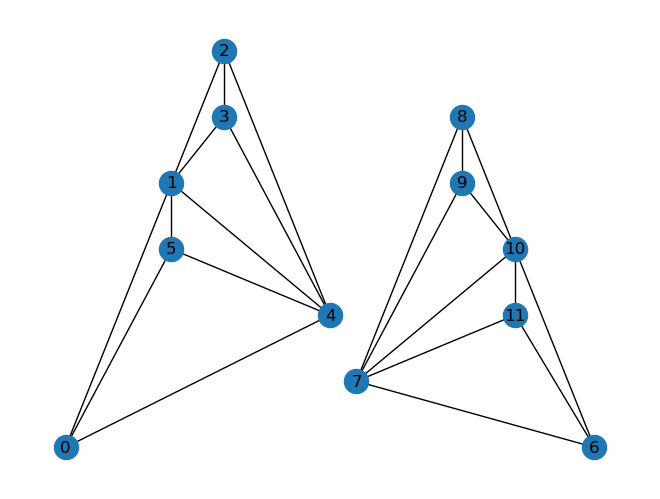

In [50]:
nx.draw_planar(G, with_labels=True)

In [51]:
manual_pos = {i: (x[0][0],x[1][0]) for i,x in enumerate(ranges)}
manual_pos

{0: (0.03338273458485588, 0.038794036230532486),
 1: (0.03357245938485589, 0.03879413921538837),
 2: (0.03376218428485589, 0.03879424220024426),
 3: (0.03376218428485589, 0.03898396700024426),
 4: (0.0335723564, 0.03898386401538837),
 5: (0.03338273458485588, 0.03898386401538837),
 6: (0.03254299028485588, 0.038795634830532486),
 7: (0.03273271518485588, 0.038795634830532486),
 8: (0.03292243998485589, 0.038795634830532486),
 9: (0.03292243998485589, 0.03898546271538837),
 10: (0.03273271518485588, 0.03898546271538837),
 11: (0.0325428873, 0.03898546271538837)}

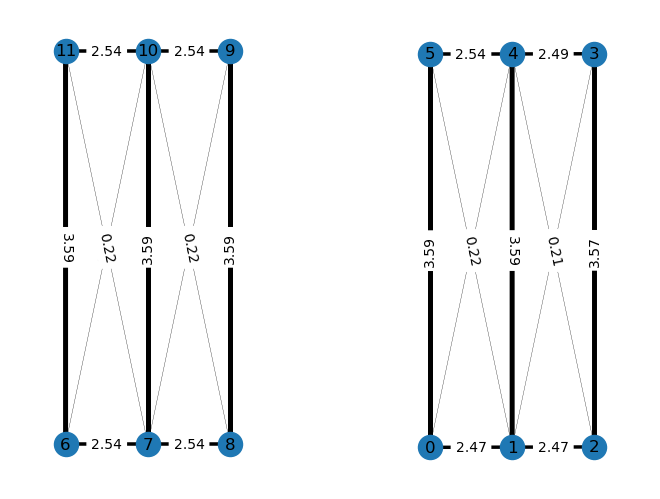

In [52]:
#pos=nx.planar_layout(G) # pos = nx.nx_agraph.graphviz_layout(G)
pos=manual_pos
labels = nx.get_edge_attributes(G,'weight')
#nx.draw_networkx(G,pos,edge_color=labels.values())
labels = {x: y*1e9 for x,y in labels.items()}
nx.draw(G, pos, width=list(labels.values()),with_labels=True)
labels = {x: f"{y:.2f}" for x,y in labels.items()}
nx.draw_networkx_edge_labels(G,pos,edge_labels=labels);


## Maximum spanning tree

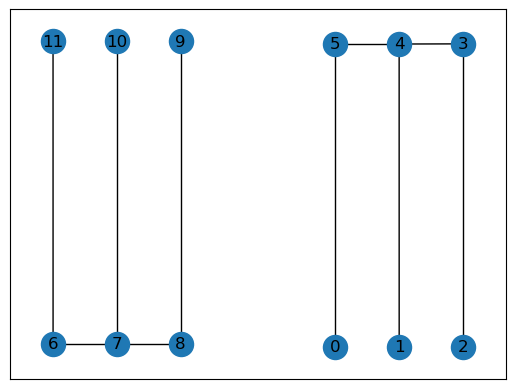

In [53]:
mst = nx.maximum_spanning_tree(G)
nx.draw_networkx(mst, manual_pos)

In [54]:
edges = list(mst.edges)
edges

[(0, 5),
 (1, 4),
 (4, 5),
 (4, 3),
 (2, 3),
 (6, 11),
 (6, 7),
 (7, 10),
 (7, 8),
 (8, 9)]

In [ ]:
[(0, 5), (1, 4), (4, 5), (4, 3), (2, 3), (6, 11), (6, 7), (7, 10), (7, 8), (8, 9)]

## Registration of overlaps along MST edges

In [ ]:
regs = []

for source, target in edges:
    source_path = f"{base_dir}/primary-fov_0{source}.nc" if source >= 10 else f"{base_dir}/primary-fov_00{source}.nc"
    target_path = f"{base_dir}/primary-fov_0{target}.nc" if target >= 10 else f"{base_dir}/primary-fov_00{target}.nc"
    source_img = xr.open_dataset(source_path).__xarray_dataarray_variable__
    target_img = xr.open_dataset(target_path).__xarray_dataarray_variable__
    source_max = source_img.max(dim=["r", "c"]).squeeze()
    target_max = target_img.max(dim=["r", "c"]).squeeze()

    px_size_x1 = source_img.xc.values[1] - source_img.xc.values[0]
    px_size_y1 = source_img.yc.values[1] - source_img.yc.values[0]
    px_size_x2 = target_img.xc.values[1] - target_img.xc.values[0]
    px_size_y2 = target_img.yc.values[1] - target_img.yc.values[0]

    if px_size_x1 != px_size_x2 or px_size_y1 != px_size_y2 or px_size_x1 != px_size_x2:
        print("WARNING: pixel sizes differ between source_img and target_img")

    range_source, range_target = get_range(source_img), get_range(target_img)
    mp_ov1, mp_ov2 = crop_overlap(source_max, target_max, range_source, range_target)

    tx_px, ty_px = registration(mp_ov1, mp_ov2, "registration_nb.json")
    tx = tx_px * px_size_x1
    ty = ty_px * px_size_y1
    
    regs.append({"source": source, "target":target, "tx": tx, "ty": ty})

regs_df = pd.DataFrame(regs)
regs_df

100%|██████████| 2/2 [00:00<00:00, 1128.41it/s]


,source,target,tx,ty
0,0,5,-3.298605e-07,7.626028e-07
1,1,4,-9.171831e-07,1.068674e-06
2,4,5,-9.459159e-07,-8.071953e-07
3,4,3,3.729082e-07,6.553956e-07
4,2,3,-6.386091e-07,3.996842e-07
5,6,11,-4.814542e-07,4.967989e-07
6,6,7,7.104925e-07,6.017405e-07
7,7,10,-7.318104e-07,3.266680e-07
8,7,8,6.748598e-07,5.820704e-07
9,8,9,-8.737235e-07,8.696041e-07


# To do

Registration differs between napari script and this script